# Camera Calibration & AprilTag Detection Demo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AccelerationConsortium/ac-training-lab/blob/main/src/ac_training_lab/apriltag_demo/apriltag_demo.ipynb)

This Jupyter Notebook provides a complete guide to AprilTag recognition using computer vision techniques. It covers how to print an AprilTag, perform camera calibration with `OpenCV`, and detect tags in captured images.

Watch the video walkthrough below:

<iframe width="560" height="315" src="https://www.youtube.com/embed/lPaUVxq59Yw?si=ylYqb_240J-u32lX" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>


To explore the demo with default files and settings, enable test mode below. If test mode is enabled, you can skip all parameter modifications in this demo.



## Configuration

In [1]:
# @markdown Set `test = True` to use default files and parameters.
test = True  # @param {type:"boolean"}

## Requirements

This notebook requires the following files and libraries. We use [one of several](https://accelerated-discovery.org/t/apriltags-which-packages-to-use-and-how-to-generate-where-to-buy/170) third-party libraries called [`pupil-apriltags`](https://github.com/pupil-labs/apriltags) which is `pip`-installable and provides Python bindings for both ID recognition and pose/distance estimation (NOTE: the official Python bindings [don't support pose estimation](https://github.com/AprilRobotics/apriltag/issues/381), only available in C).

In [2]:
# only install if we are running in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    %pip install opencv-python pupil-apriltags reportlab matplotlib scipy numpy

## Hardware Preparation

You will need to print a checkerboard pattern and an AprilTag image.

### Print a Checkerboard Pattern

To calibrate your camera, you will need a printed checkerboard pattern. You can download a standard A4 checkerboard from [here](https://raw.githubusercontent.com/opencv/opencv/master/doc/pattern.png) or [a PDF autogenerated via `calib.io`](https://calib.io/pages/camera-calibration-pattern-generator). Print it out and attach it to a flat surface. If using `calib.io`, to match with the default settings in this notebook, set rows to `7`, columns to `10`, and Checker Width to `23`, shown below. Please spot-check by measuring the printed checker width with a ruler.

A static PDF of that checkerboard in A4 paper size (`width=297mm`, `height=210mm`) is provided in [`calib.io_checker_297x210_7x10_23.pdf`](calib.io_checker_297x210_7x10_23.pdf). Letter size (`width=279mm`, `height=216mm`) is also provided in [`calib.io_checker_279x216_7x10_23.pdf`](calib.io_checker_279x216_7x10_23.pdf).


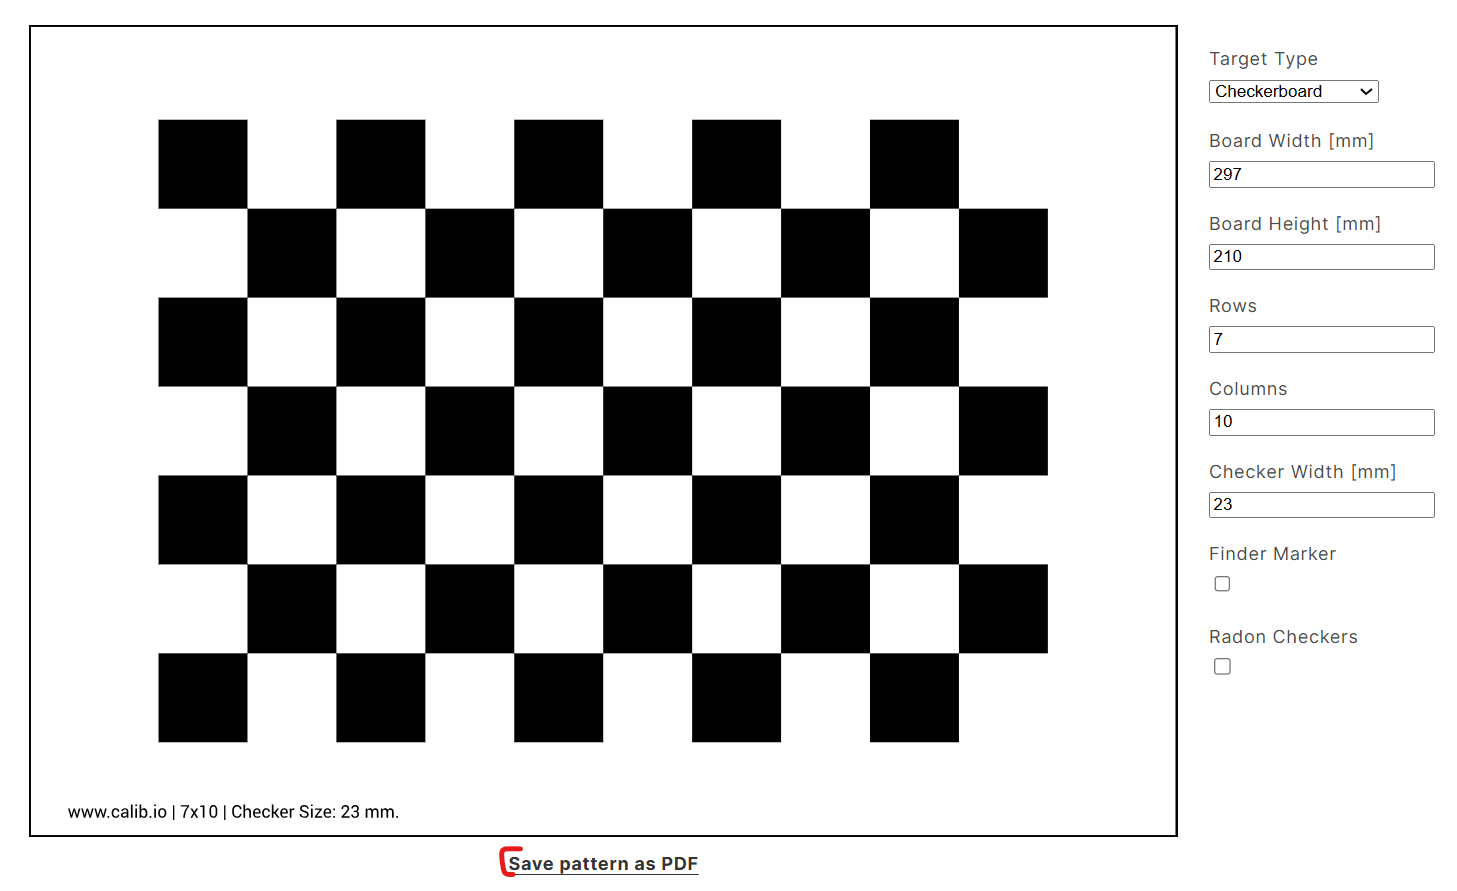

When printing, you may need to set your printer to "borderless" to avoid a slight mismatch in actual print size (e.g., 22 mm instead of 23 mm). For an EPSON ET-16600 series printer, assuming you're printing it via Foxit Reader, click "Properties" → "Advanced", then turn the "Borderless" option on. If you have slight mismatches with your printer, try Googling `"print size is slightly off"` along with your printer brand or model.

![borderless](./foxit-reader-print-settings-borderless.png)

### Get AprilTag Images
You can download an example AprilTag [`tag41_12_00110.pdf`](example_apriltag/tag41_12_00110.pdf) (A4 size), or follow the steps below to generate a custom tag with your desired size, family, and paper size. If you choose to use the example tag, you can jump to Camera Calibration. You can find images for pregenerated tags in the [apriltag-imgs repo](https://github.com/AprilRobotics/apriltag-imgs).

> Note: "For the vast majority of applications, the tagStandard41h12 family will be the correct choice. Scale up the images in your favorite editor and print them out or use the helper function below to automatically generate a printable SVG version of the tag at your desired size.
>
> Some heuristics for when to choose other tag families:
>
> 1. If you need more tags, use tagStandard52h13
> 2. If you need to maximize the use of space on a small circular object, use tagCircle49h12 (or tagCircle21h7).
> 3. If you want to make a recursive tag use tagCustom48h12.
> 4. If you want compatibility with the ArUcO detector use tag36h11
>
> If none of these fit your needs, generate your own custom tag family [here](https://github.com/AprilRobotics/apriltag-generation)."

— *Source: [AprilTag GitHub README – Choosing a Tag Family](https://github.com/AprilRobotics/apriltag?tab=readme-ov-file#choosing-a-tag-family)*


Below is a helper function for generating a PDF version of an AprilTag centered on the page.

- `tag`: the full name of the tag, e.g., "tag41_12_00110".
- `page_size`: the size of the paper to use (e.g., `A4` or `LETTER` from `reportlab.lib.pagesizes`).
- `bounding_box_size_mm`: the size of the square area (in millimeters) that bounds the AprilTag. This defines how large the tag will appear on the printed page.
> Note: The actual printed size may differ slightly from the specified size due to printer inaccuracies.

In [3]:
# @title Generate PDF AprilTag
tag = "tag41_12_00110" # @param {type:"string"}
page_size = "A4"  # @param ["A4", "LETTER"]
bounding_box_size_mm = 45 # @param {type:"number"}

In [4]:
import os
import requests
from PIL import Image
from reportlab.pdfgen import canvas
from reportlab.lib.units import mm
from reportlab.lib.pagesizes import A4, LETTER

def infer_tag_family(tag_name: str) -> str:
    """Infer the AprilTag family from tag name like tag41_12_00000 using a mapping."""
    prefix_map = {
        "16": "tag16h5",
        "25": "tag25h9",
        "36": "tag36h11",
        "21": "tagCircle21h7",
        "49": "tagCircle49h12",
        "48": "tagCustom48h12",
        "41": "tagStandard41h12",
        "52": "tagStandard52h13"
    }

    parts = tag_name.split("_")
    if len(parts) < 3:
        raise ValueError(f"Invalid tag name format: {tag_name}")

    key = f"{parts[0][3:]}"  # strip "tag" and e.g. "16"
    if key in prefix_map:
        return prefix_map[key]
    else:
        raise ValueError(f"Unknown tag family for tag name: {tag_name}")


def download_apriltag(tag_name: str):
    """Download AprilTag PNG if not already cached."""
    png_filename = f"{tag_name}.png"
    tag_family = infer_tag_family(tag_name)
    if not os.path.exists(png_filename):
        png_url = f"https://raw.githubusercontent.com/AprilRobotics/apriltag-imgs/master/{tag_family}/{png_filename}"
        r = requests.get(png_url)
        with open(png_filename, "wb") as f:
            f.write(r.content)
    return png_filename

def generate_apriltag_pdf(tag_name: str, bounding_box_size_mm: int, page_type="A4"):
    """Generate a PDF with an AprilTag at precise physical dimensions."""

    if page_type == "A4":
        page_size = A4
    elif page_type == "LETTER":
        page_size = LETTER

    png_filename = download_apriltag(tag_name)
    pdf_filename = f"{tag_name}_{bounding_box_size_mm}mm.pdf"

    # Create PDF
    c = canvas.Canvas(pdf_filename, pagesize=page_size)
    page_width, page_height = page_size

    # Center the tag on page
    tag_size = bounding_box_size_mm * mm
    x = (page_width - tag_size) / 2
    y = (page_height - tag_size) / 2

    # Draw tag
    c.drawImage(png_filename, x, y, width=tag_size, height=tag_size)

    # Add label
    c.setFont("Helvetica", 12)
    text = f"{tag_name} ({bounding_box_size_mm}mm)"
    text_width = c.stringWidth(text, "Helvetica", 12)
    c.drawString((page_width - text_width) / 2, y - 20, text)

    c.save()
    return pdf_filename

In [5]:
pdf_filename = generate_apriltag_pdf(tag, bounding_box_size_mm, page_type=page_size)

if IN_COLAB:
    from google.colab import files
    files.download(f"{pdf_filename}")

[[example output PDF](./tag41_12_00110_45mm_static_for_docs.pdf)]

Below is a helper function for generating a scalable SVG version of an AprilTag from a PNG image.

- `tag`: the full name of the tag, e.g., `"tag41_12_00110"`.

In [6]:
# @title Generate SVG AprilTag
tag = "tag41_12_00110" # @param {type:"string"}

In [7]:
def generate_apriltag_svg(tag_name: str, bounding_box_size_mm: int = 45):
    """Generate an SVG with an AprilTag at precise physical dimensions."""

    png_filename = download_apriltag(tag_name)
    svg_filename = f"{tag_name}_{bounding_box_size_mm}mm.svg"

    # Convert PNG to SVG using original approach
    def gen_rgba(rgba):
        (_r, _g, _b, _raw_a) = rgba
        _a = _raw_a / 255
        return f'rgba({_r}, {_g}, {_b}, {_a})'

    def gen_gridsquare(row_num, col_num, pixel):
        _rgba = gen_rgba(pixel)
        _id = f'box{row_num}-{col_num}'
        return f'\t<rect width="1" height="1" x="{row_num}" y="{col_num}" fill="{_rgba}" id="{_id}"/>\n'

    def gen_apriltag_svg(width, height, pixel_array, size):
        svg_text = '<?xml version="1.0" standalone="yes"?>\n'
        svg_text += f'<svg width="{size}" height="{size}" viewBox="0,0,{width},{height}" xmlns="http://www.w3.org/2000/svg">\n'
        for _y in range(height):
            for _x in range(width):
                svg_text += gen_gridsquare(_x, _y, pixel_array[_x, _y])
        svg_text += '</svg>\n'
        return svg_text

    with Image.open(png_filename, 'r') as im:
        width, height = im.size
        pix_vals = im.load()
        svg_text = gen_apriltag_svg(width, height, pix_vals, f"{bounding_box_size_mm}mm")

    with open(svg_filename, 'w') as fp:
        fp.write(svg_text)

    return svg_filename

In [8]:
svg_filename = generate_apriltag_svg(tag)

if IN_COLAB:
    from google.colab import files
    files.download(f"{svg_filename}")

[*Example output SVG*](./tag41_12_00110_45mm.svg)

![example output SVG](./tag41_12_00110_45mm.svg)


You can use the generated PDF or SVG files directly or insert the image(s) into an editor (e.g., Microsoft Word, Pages, Google Docs, Google Drawings, Inkscape) to adjust its printed size as needed. Note that many editors may not respect the true scaling and may result in blurriness or distortion due to unwanted interpolation. SVG won't have this problem, but SVG isn't a supported filetype for Google Docs or Google Drawings. Be careful also of scaling settings when printing, as mentioned earlier in the checkerboard section. We recommend measuring the printed tag to verify the final dimensions.

![foxit settings](./foxit-reader-print-settings.png)

As an extra, here's a function for generating a sheet of tags. 

- tag_str: The tag names as a comma-separated string (e.g., "tag41_12_00000, tag41_12_00001"). 
- bounding_box_size_mm: The size of the square area (in millimeters) that bounds the AprilTag. This defines how large the tag will appear on the printed page.
- tags_per_row: The number of tags to place in each row.

> Note: If you modify `bounding_box_size_mm`, you may also need to adjust `tags_per_row` to ensure all tags fit well on the page.

In [9]:
# @title Generate a sheet of tags
tag_str = "tag41_12_00110, tag25_09_00000, tag36_11_00000, tag49_12_00000"  # @param {type:"string"}
bounding_box_size_mm = 45 # @param {type:"number"}
tags_per_row = 3  # @param {type:"integer"}
tag_list = [tag.strip() for tag in tag_str.split(",")]

In [10]:
def generate_tag_sheet_pdf(tag_list: list,
                          bounding_box_size_mm: int = 45, tags_per_row: int = 3, page_size="A4"):
    """Generate a PDF sheet with multiple tags."""

    if page_size == "A4":
        page_size = A4
    elif page_size == "LETTER":
        page_size = LETTER

    filename = "apriltag_sheet.pdf"

    # Download all tags
    for tag_name in tag_list:
        download_apriltag(tag_name)

    # Create PDF
    c = canvas.Canvas(filename, pagesize=page_size)
    page_width, page_height = page_size

    tag_size = bounding_box_size_mm * mm
    margin = 20 * mm
    spacing = 15 * mm

    for i, tag_name in enumerate(tag_list):
        row = i // tags_per_row
        col = i % tags_per_row

        x = margin + col * (tag_size + spacing)
        y = page_height - margin - (row + 1) * (tag_size + spacing)

        png_filename = f"{tag_name}.png"
        
        img = Image.open(png_filename)
        
        if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):
            # Create a white background
            background = Image.new('RGB', img.size, (255, 255, 255))
            
            # Paste the image onto the white background
            if img.mode == 'P':
                img = img.convert('RGBA')
            background.paste(img, mask=img.split()[-1] if img.mode == 'RGBA' else None)
            
            # Save the composited image temporarily
            temp_filename = f"temp_{tag_name}.png"
            background.save(temp_filename)
            
            # Draw the composited image
            c.drawImage(temp_filename, x, y, width=tag_size, height=tag_size)
            
            # Clean up temp file
            os.remove(temp_filename)
        else:
            c.drawImage(png_filename, x, y, width=tag_size, height=tag_size)

        # Tag name below
        c.setFont("Helvetica", 8)
        text = tag_name
        text_width = c.stringWidth(text, "Helvetica", 8)
        c.drawString(x + (tag_size - text_width) / 2, y - 12, text)

    c.save()
    return filename

In [11]:
tag_sheet_filename = generate_tag_sheet_pdf(tag_list, bounding_box_size_mm, tags_per_row)

if IN_COLAB:
    from google.colab import files
    files.download(tag_sheet_filename)

[[example tag sheet](./apriltag_sheet_static_for_docs.pdf)]

## Camera Calibration

Follow the guidelines to capture photos and then run the calibration script.

### 1. Camera Calibration Photo Guide

Camera calibration requires using the printed checkerboard and the camera you want to calibrate. Please follow the guidelines below when capturing images of the checkerboard:

- Use the same printed checkerboard for all photos.
- Place the checkerboard on a flat and rigid surface to avoid distortion.
- Use even lighting and make sure the checkerboard is sharp, unobstructed, and fully within the frame。
- Capture checkerboard images from a variety of positions, distances, and angles to improve calibration accuracy.
- Capture at least 10 images, ideally 15–20, from different angles and distances.
- Save all images in a consistent format such as .jpg or .png, and ensure that all images have the same resolution.

After calibration, store all images in one folder.

We provide a set of hard-coded checkerboard images in a [ZIP file](checkerboard_images.zip), manually captured for camera calibration purposes. Below are two sample images from the set:
<p align="center">
  <img src="https://images.weserv.nl/?url=drive.google.com/uc?id=1zcOI8qm66jzLp7icGdK0QkAoDe6242LN" width="500"/>
  <img src="https://images.weserv.nl/?url=drive.google.com/uc?id=1VQm7praOF-hAJWy9hWhg3dnKDokBXhug" width="500"/>
</p>





### 2. Run Camera Calibration with Checkerboard Images

Run the cell below to either  use the pre-supplied ones (set `test=True` at top) or upload your own checkerboard images (set `test=False` at top). If you're using your own checkerboard images and running outside of Google Colab, insert your images in the `image_dir` folder (by default `./checkerboard_images`).

In [12]:
import os
import sys
import zipfile
import urllib.request
import shutil

if IN_COLAB:
    image_dir = "/content/checkerboard_images"
else:
    image_dir = os.path.abspath("checkerboard_images")

os.makedirs(image_dir, exist_ok=True)

def download_and_flatten_unzip(url, extract_dir):
    zip_path = os.path.join(extract_dir, "checkerboard_images.zip")
    urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for member in zip_ref.namelist():
            filename = os.path.basename(member)
            if not filename:
                continue
            source = zip_ref.open(member)
            target_path = os.path.join(extract_dir, filename)
            with open(target_path, "wb") as target:
                shutil.copyfileobj(source, target)

if test:
    zip_url = "https://raw.githubusercontent.com/AccelerationConsortium/ac-training-lab/main/src/ac_training_lab/apriltag_demo/checkerboard_images.zip"
    download_and_flatten_unzip(zip_url, image_dir)
else:
    if IN_COLAB:
        # Check for existing files in the folder
        existing_files = os.listdir(image_dir)
        if existing_files:
            print(f"Warning: The folder {image_dir} already contains files. Uploading new files will delete all existing files.")
            confirm = input("Do you want to proceed? (Y/N): ").strip().lower()
            if confirm != "y":
                print("Operation canceled. No files were uploaded.")
                sys.exit()

        # Clear the folder before uploading
        for file in existing_files:
            os.remove(os.path.join(image_dir, file))

        from google.colab import files
        uploaded = files.upload()
        for name in uploaded.keys():
            os.rename(name, os.path.join(image_dir, name))

image_paths = [
    os.path.join(image_dir, f)
    for f in sorted(os.listdir(image_dir))
    if f.lower().endswith(('.jpg', '.png'))
]

print(image_paths)

['f:\\AC\\ac-training-lab\\src\\ac_training_lab\\apriltag_demo\\checkerboard_images\\WIN_20250521_16_50_58_Pro.jpg', 'f:\\AC\\ac-training-lab\\src\\ac_training_lab\\apriltag_demo\\checkerboard_images\\WIN_20250521_16_51_15_Pro.jpg', 'f:\\AC\\ac-training-lab\\src\\ac_training_lab\\apriltag_demo\\checkerboard_images\\WIN_20250521_16_51_21_Pro.jpg', 'f:\\AC\\ac-training-lab\\src\\ac_training_lab\\apriltag_demo\\checkerboard_images\\WIN_20250521_16_51_38_Pro.jpg', 'f:\\AC\\ac-training-lab\\src\\ac_training_lab\\apriltag_demo\\checkerboard_images\\WIN_20250521_16_51_49_Pro.jpg', 'f:\\AC\\ac-training-lab\\src\\ac_training_lab\\apriltag_demo\\checkerboard_images\\WIN_20250521_16_52_01_Pro.jpg', 'f:\\AC\\ac-training-lab\\src\\ac_training_lab\\apriltag_demo\\checkerboard_images\\WIN_20250521_16_52_11_Pro.jpg', 'f:\\AC\\ac-training-lab\\src\\ac_training_lab\\apriltag_demo\\checkerboard_images\\WIN_20250521_16_52_16_Pro.jpg', 'f:\\AC\\ac-training-lab\\src\\ac_training_lab\\apriltag_demo\\checkerb

You should modify the following three parameters to calibrate your camera.

- `rows`: the number of inner corners in the vertical direction.

- `cols`: the number of inner corners in the horizontal direction.

> NOTE: These refer to the number of corner intersections, not the number of squares.

- `square_size_mm`: the length of one square on the checkerboard, in mm (spot-check this with a ruler)

In [13]:
# @title Calibrate Camera
rows = 6 # @param {type:"integer"}
cols = 9 # @param {type:"integer"}

square_size_mm = 23  # @param {type:"number"}

In [14]:
import numpy as np
import cv2
from typing import List, Tuple
import matplotlib.pyplot as plt

def calibrate_camera_from_images(
    image_paths: List[str],
    rows: int,
    cols: int,
    square_size: float,
    show_detections: bool = False,
    save_path: str = None
) -> Tuple[np.ndarray, Tuple[float, float, float, float]]:
    pattern_size = (cols, rows) if rows < cols else (rows, cols)

    x = np.arange(pattern_size[0]) * square_size
    y = np.arange(pattern_size[1]) * square_size
    xgrid, ygrid = np.meshgrid(x, y)
    zgrid = np.zeros_like(xgrid)
    opoints = np.dstack((xgrid, ygrid, zgrid)).reshape((-1, 1, 3)).astype(np.float32)

    imagesize = None
    ipoints = []

    for filename in image_paths:
        rgb = cv2.imread(filename)
        if rgb is None:
            print(f'Error loading {filename}, skipping.')
            continue

        if imagesize is None:
            imagesize = (rgb.shape[1], rgb.shape[0])
        else:
            assert imagesize == (rgb.shape[1], rgb.shape[0]), "Inconsistent image sizes."

        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY) if len(rgb.shape) == 3 else rgb
        found, corners = cv2.findChessboardCorners(gray, pattern_size)

        if show_detections:
            display_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
            cv2.drawChessboardCorners(display_img, pattern_size, corners, found)
            plt.figure(figsize=(8, 6))
            plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

        if found:
            ipoints.append(corners)
        else:
            print(f'No corners found in {filename}, skipping.')

    if len(ipoints) < 1:
        raise ValueError("No valid images with detected corners found.")

    flags = (cv2.CALIB_ZERO_TANGENT_DIST |
             cv2.CALIB_FIX_K1 |
             cv2.CALIB_FIX_K2 |
             cv2.CALIB_FIX_K3 |
             cv2.CALIB_FIX_K4 |
             cv2.CALIB_FIX_K5 |
             cv2.CALIB_FIX_K6)

    retval, K, dcoeffs, rvecs, tvecs = cv2.calibrateCamera(
        [opoints] * len(ipoints),
        ipoints,
        imagesize,
        cameraMatrix=None,
        distCoeffs=np.zeros(5),
        flags=flags
    )

    fx, fy, cx, cy = K[0,0], K[1,1], K[0,2], K[1,2]
    if save_path:
        np.save(save_path, np.array([fx, fy, cx, cy]))
        print(f'Saved camera parameters to {save_path}')

    print("\nCamera intrinsics (units: pixels):")
    print(f"  fx = {fx:.3f}")
    print(f"  fy = {fy:.3f}")
    print(f"  cx = {cx:.3f}")
    print(f"  cy = {cy:.3f}")
    print(f"\nPython copy-paste: fx, fy, cx, cy = {(fx, fy, cx, cy)}")

    return K, (fx, fy, cx, cy)

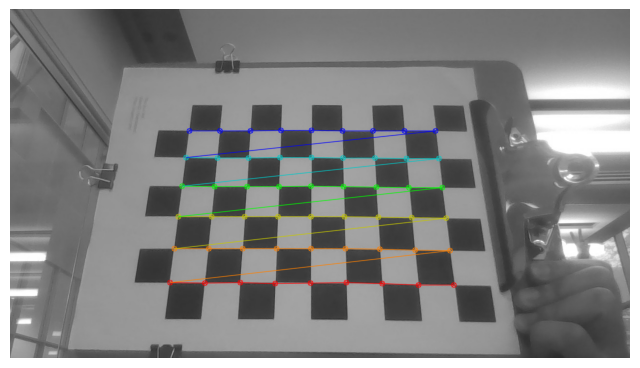

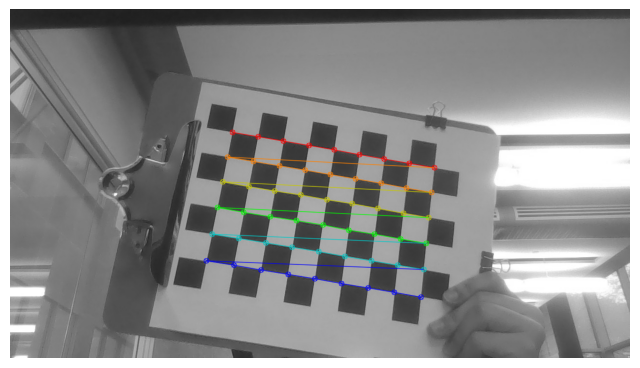

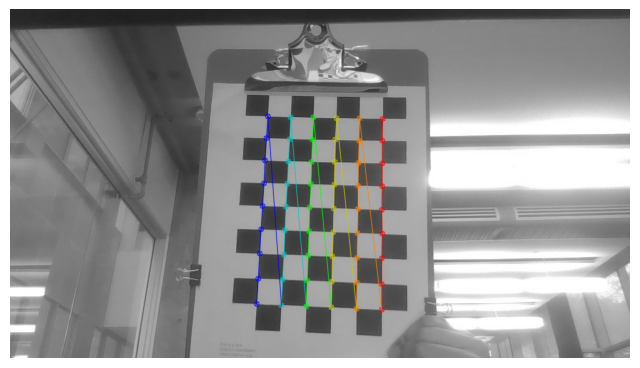

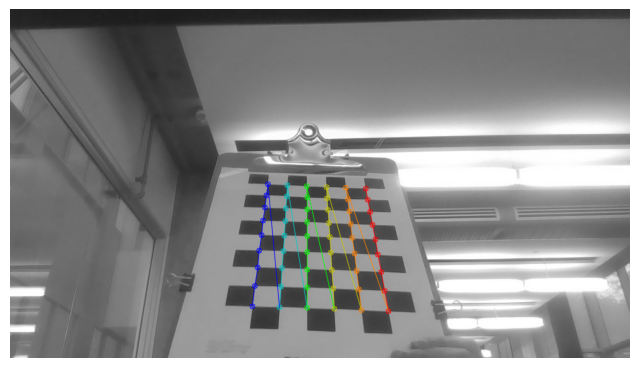

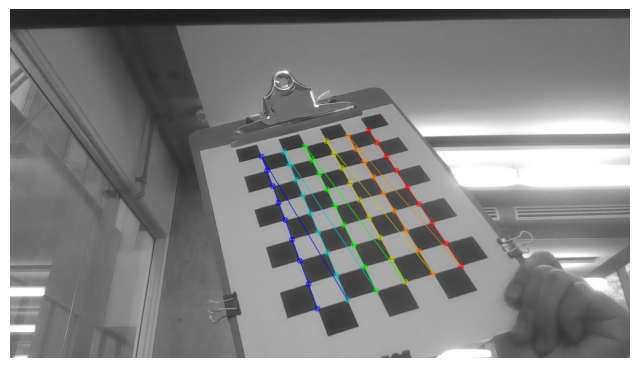

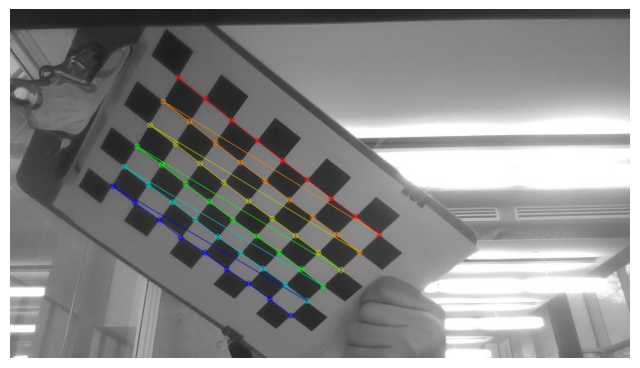

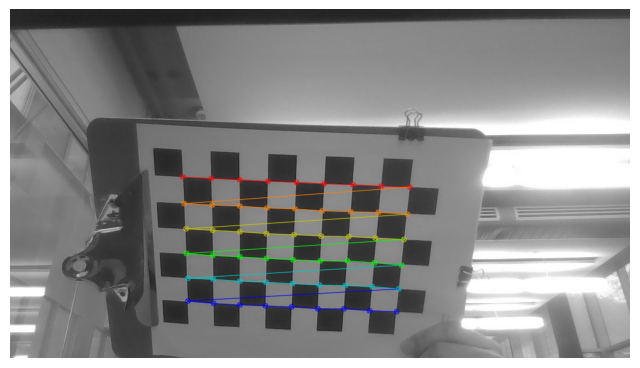

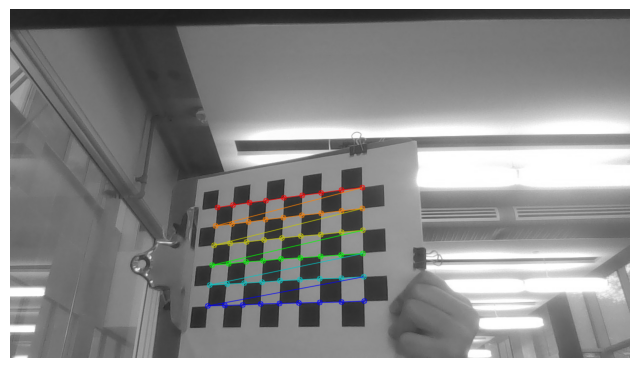

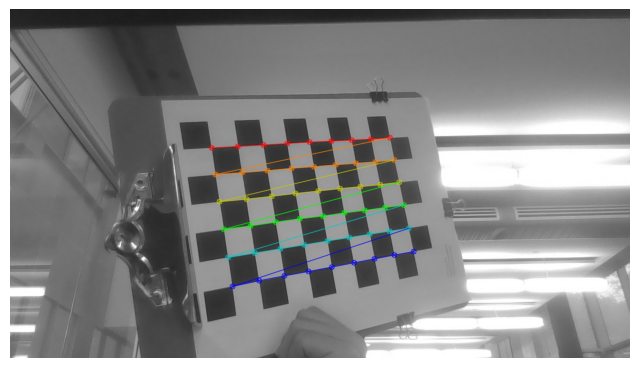

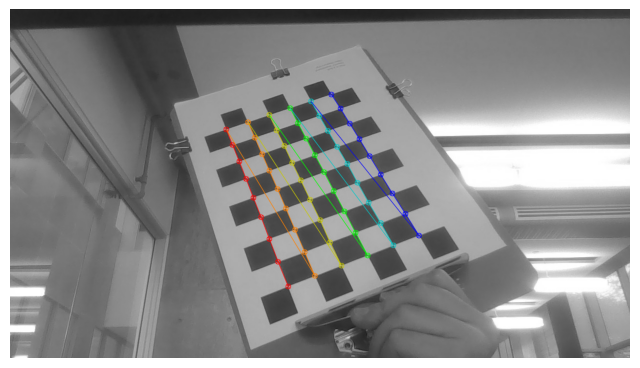

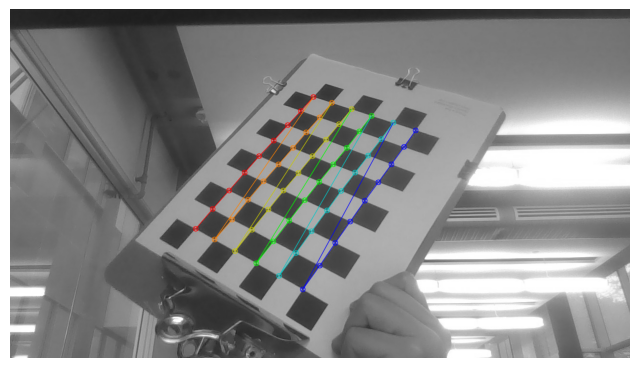

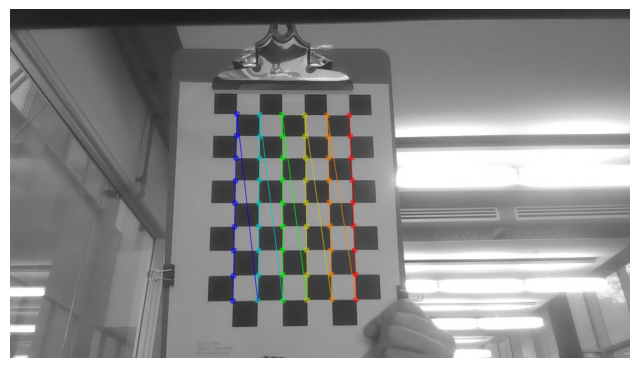

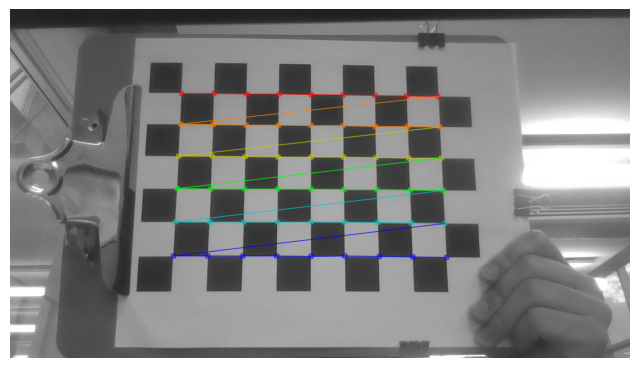

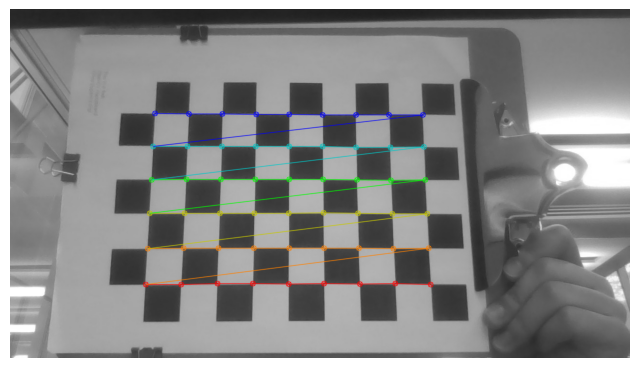

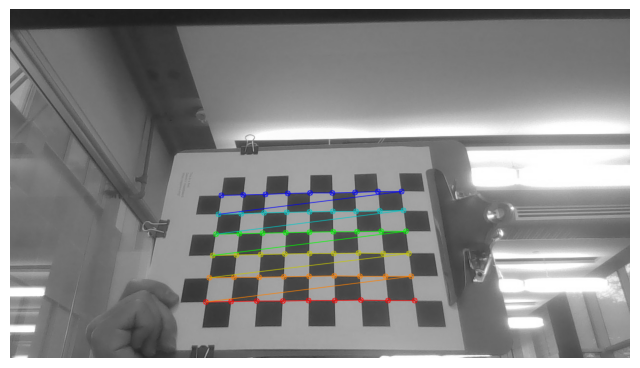

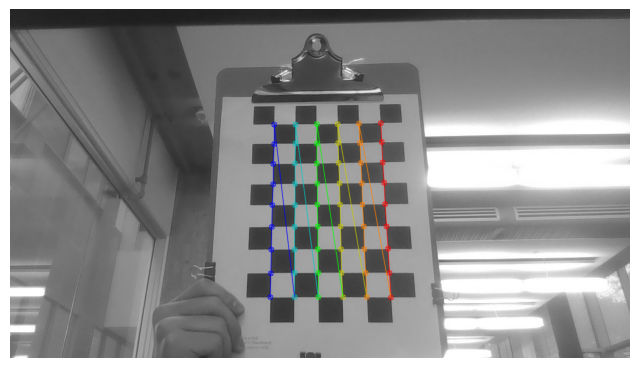

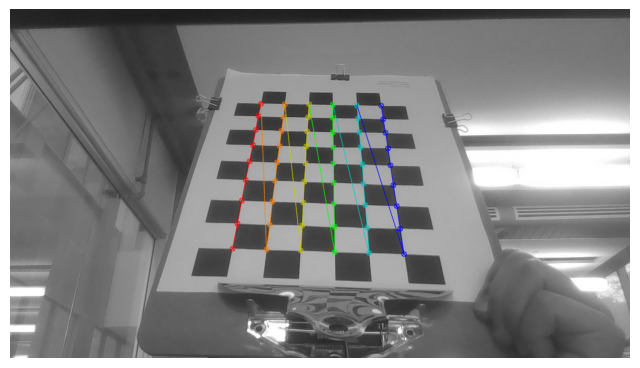

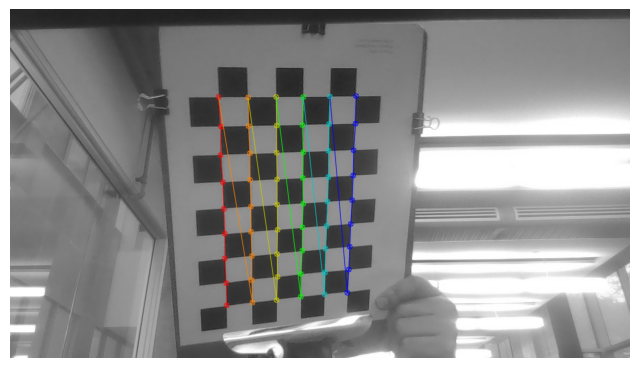

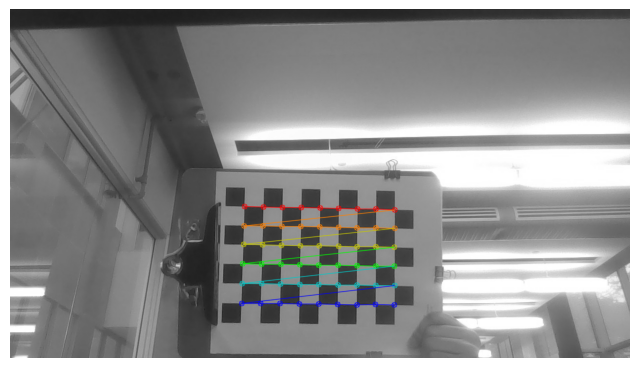

FileNotFoundError: [Errno 2] No such file or directory: '/content/camera_params.npy'

In [15]:
K, (fx, fy, cx, cy) = calibrate_camera_from_images(
    image_paths=image_paths,
    rows=rows,
    cols=cols,
    square_size=square_size_mm,
    show_detections=True,
    save_path="/content/camera_params.npy"
)

---

## AprilTag Detection

Run the cell below to upload your own captured picture of an AprilTag (if you set `test=False` at the beginning) or use [a pre-supplied one](apriltag_test.jpg) (`test=True`), shown below:

![apriltag_test.jpg](https://raw.githubusercontent.com/AccelerationConsortium/ac-training-lab/apriltag_demo/src/ac_training_lab/apriltag_demo/apriltag_test.jpg)

In [ ]:
if test:
    import urllib.request
    apriltag_url = "https://raw.githubusercontent.com/AccelerationConsortium/ac-training-lab/main/src/ac_training_lab/apriltag_demo/apriltag_test.jpg"
    apriltag_path = "apriltag_test.jpg"
    urllib.request.urlretrieve(apriltag_url, apriltag_path)
elif IN_COLAB:
    from google.colab import files
    uploaded = files.upload()
    if len(uploaded) == 0:
        raise ValueError("No image uploaded.")
    apriltag_filename = next(iter(uploaded))
    apriltag_path = os.path.join("/content", apriltag_filename)
else:
    apriltag_path = input("Enter the path to the AprilTag image: ")
    if not os.path.exists(apriltag_path):
        raise ValueError(f"File {apriltag_path} does not exist.")
    apriltag_path = os.path.abspath(apriltag_path)

You should modify the following two parameters to recognize the apriltag.

- `families`: the tag family the AprilTag belongs to (e.g., `tag16h5`, `tagStandard41h12`, `tag36h11`, etc.).

- `tagsize_mm`: The size of the tag in millimeters (different from the bounding box size).

> Note: "Each tag design has a black border and a white border, but some designs have the white border on the inside and some have the black border on the inside. The tagsize is thus measured from where the two borders meet, see the figure below for an example. The tag size should not be measured from the outside of the tag. The tag size is defined as the distance between the detection corners, or alternately, the length of the edge between the white border and the black border. The following illustration marks the detection corners with red Xs and the tag size with a red arrow for a tag from the 48h12Custom tag family."

— *Source: [AprilTag GitHub README – Pose Estimation](https://github.com/AprilRobotics/apriltag?tab=readme-ov-file#pose-estimation)*
<p align="center">
  <img src="https://raw.githubusercontent.com/AprilRobotics/apriltag/master/tag_size_48h12.png" alt="AprilTag Example" width="400">
</p>

In [ ]:
# @title AprilTag Detection
# @markdown Configure detection parameters and run detection on the image.

families = "tagStandard41h12"  # @param ["tag16h5", "tag25h9", "tag36h11", "tagCircle21h7", "tagCircle49h12", "tagCustom48h12", "tagStandard41h12", "tagStandard52h13"]
tagsize_mm = 45 # @param {type:"number"}
tagsize_meters = tagsize_mm / 1000


Found 1 tags

Tag ID: 110
  Center: [749.37644969 422.11163324]
  Corners: [[662.08197021 510.15979004]
 [837.67254639 508.87594604]
 [837.706604   333.01885986]
 [660.6194458  334.89440918]]
  Translation (x, y, z): [0.03753592 0.01313283 0.24088217]
  Distance from camera: 24.41 centimeters
  Roll: 2.31°, Pitch: 0.68°, Yaw: -0.56°


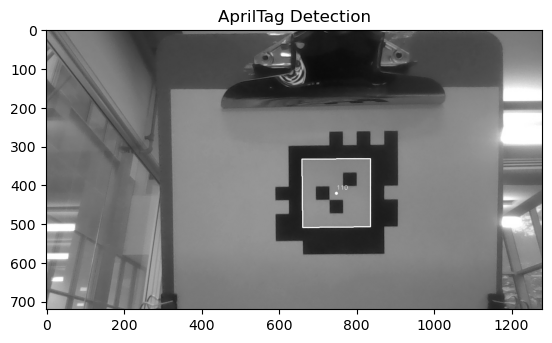

In [ ]:
import cv2
import numpy as np
from pupil_apriltags import Detector
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

image = cv2.imread(apriltag_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError(f"Failed to load image at {apriltag_path}")

camera_params = np.load("/content/camera_params.npy")

at_detector = Detector(
    families=families,
    nthreads=1,
    quad_decimate=1.0,
    quad_sigma=0.0,
    refine_edges=1,
    decode_sharpening=0.25,
    debug=0
)

detections = at_detector.detect(
    image,
    estimate_tag_pose=True,
    camera_params=camera_params,
    tag_size=tagsize_meters
)

print(f"Found {len(detections)} tags")

for det in detections:
    tag_id = det.tag_id
    center = det.center
    corners = det.corners.astype(int)

    cv2.polylines(image, [corners], True, 255, 2)
    cx, cy = map(int, center)
    cv2.circle(image, (cx, cy), 4, 255, -1)
    cv2.putText(image, str(tag_id), (cx, cy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255, 1)

    print(f"\nTag ID: {tag_id}")
    print(f"  Center: {center}")
    print(f"  Corners: {det.corners}")

    if det.pose_t is not None:
        t = det.pose_t.flatten()
        print(f"  Translation (x, y, z): {t}")

        distance_cm = np.linalg.norm(t) * 100
        print(f"  Distance from camera: {distance_cm:.2f} centimeters")

        euler = R.from_matrix(det.pose_R).as_euler('xyz', degrees=True)
        roll, pitch, yaw = euler
        print(f"  Roll: {roll:.2f}°, Pitch: {pitch:.2f}°, Yaw: {yaw:.2f}°")
    else:
        print("No pose estimated (pose_t is None)")

plt.imshow(image, cmap='gray')
plt.title("AprilTag Detection")
plt.show()

### Output Field Explanation

- **Tag ID**: The unique identifier of the detected AprilTag.

- **Center**: The (x, y) pixel coordinates of the tag's center in the image.

- **Corners**: The pixel coordinates of the tag’s four corners, typically ordered counterclockwise.

The camera coordinate system follows OpenCV's default convention:

- x-axis: right  
- y-axis: down  
- z-axis: forward (into the scene)

- **Translation (x, y, z)**: The tag’s 3D position relative to the camera, in centimeters:
  - x: horizontal offset (left/right)
  - y: vertical offset (up/down)
  - z: distance from the camera (depth)

- **Distance from camera**: The Euclidean distance between the camera and the tag’s center in 3D space.

- **Roll, Pitch, Yaw**: The tag’s rotation angles relative to the camera, in degrees:
  - Roll: rotation around the x-axis
  - Pitch: rotation around the y-axis
  - Yaw: rotation around the z-axis


## Additional Resources
- Accelerated Discovery Forum: [AprilTags - which packages to use and how to generate / where to buy](https://accelerated-discovery.org/t/apriltags-which-packages-to-use-and-how-to-generate-where-to-buy/170)
- Manuscript: [Robotic integration for end-stations at scientific user facilities](https://doi.org/10.1039/D5DD00036J)
- Manuscript: [Review of low-cost self-driving laboratories in chemistry and materials science: the “frugal twin” concept](https://doi.org/10.1039/D3DD00223C) (Section 4.2.1)
- Manuscript: [Experimental Comparison of Fiducial Markers for Pose Estimation](https://doi.org/10.1109/ICUAS48674.2020.9213977)